# Plot three-panel plot of cloud base height distribution from w-band, SEA-POL echo base height distribution, and spatial map of echo base height

- cloud base  height from cloudnet product
- echo base height from SEA-POL volume level 4b

In [21]:
import xarray as xr
import numpy as np
import pandas as pd

from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import cftime
import json
import glob
import os

import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns

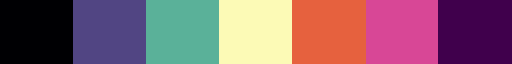

In [22]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 7)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='lightgray') #set missing (NaN) values to gray

discrete_mask_cmap

W-band cloud radar

In [23]:
# Read in data
#QmSw6jc9FrcY6tcnKw2bvHJ2NYwS5WwRjSsPxNM4fcVvTr
#wband = xr.open_dataset("ipfs://bafybeiceihwds4qy6nqxfpp7qqot7xjlpjrtv5yq3t6uwnupk3bawhnbte", engine="zarr")
wband = xr.open_dataset("ipns://latest.orcestra-campaign.org/products/METEOR/cloudnet.zarr", engine="zarr")
wband

<xarray.Dataset> Size: 7GB
Dimensions:                 (time: 106200, height: 393)
Coordinates:
  * height                  (height) float32 2kB 120.3 135.3 ... 1.198e+04
  * time                    (time) datetime64[ns] 850kB 2024-08-17T00:00:15 ....
Data variables: (12/55)
    N_scaled                (time, height) float32 167MB ...
    Tw                      (time, height) float32 167MB ...
    Z                       (time, height) float32 167MB ...
    Z_bias                  (time) float32 425kB ...
    Z_error                 (time, height) float32 167MB ...
    Z_sensitivity           (time, height) float32 167MB ...
    ...                      ...
    rain_detected           (time) float64 850kB ...
    rainfall_rate           (time) float32 425kB ...
    target_classification   (time, height) float64 334MB ...
    v                       (time, height) float32 167MB ...
    v_sigma                 (time, height) float32 167MB ...
    width                   (time, height) float32 167MB ...
Attributes: (12/18)
    Conventions:         CF-1.8
    cloudnet_file_type:  der
    title:               Cloudnet droplet effective radius on RV Meteor durin...
    location:            RV Meteor
    year:                2024
    source:              RPG-Radiometer Physics RPG-FMCW-94\nLufft CHM15k\nEC...
    ...                  ...
    platform:            RV METEOR
    institution:         Leipzig Institute for Meteorology, Leipzig University
    instrument:          Cloudnet product based on cloud radar, ceilometer, m...
    creator_id:          ORCiD: 0000-0002-1164-3576
    keywords:            Cloudnet, effective radius, droplet
    featureType:         trajectoryProfile

SEA-POL data

In [24]:
# read in data
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_volume_3D.nc')
seapol

<xarray.Dataset> Size: 346GB
Dimensions:       (time: 7761, Z: 19, Y: 241, X: 241)
Coordinates:
  * X             (X) float32 964B -1.2e+05 -1.19e+05 ... 1.19e+05 1.2e+05
  * Y             (Y) float32 964B -1.2e+05 -1.19e+05 ... 1.19e+05 1.2e+05
  * Z             (Z) float32 76B 0.0 1e+03 2e+03 ... 1.6e+04 1.7e+04 1.8e+04
    latitude      (time, Y, X) float32 2GB ...
    longitude     (time, Y, X) float32 2GB ...
  * time          (time) datetime64[ns] 62kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables: (12/14)
    DBZ           (time, Z, Y, X) float32 34GB ...
    KDP           (time, Z, Y, X) float32 34GB ...
    PHIDP         (time, Z, Y, X) float32 34GB ...
    RAINRATE      (time, Z, Y, X) float32 34GB ...
    RHOHV         (time, Z, Y, X) float32 34GB ...
    SQI           (time, Z, Y, X) float32 34GB ...
    ...            ...
    WIDTH         (time, Z, Y, X) float32 34GB ...
    ZDR           (time, Z, Y, X) float32 34GB ...
    grid_mapping  int32 4B ...
    heading       (time) float32 31kB ...
    start_time    (time) datetime64[ns] 62kB ...
    stop_time     (time) datetime64[ns] 62kB ...
Attributes: (12/16)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0
    history:           Thu Jun 26 07:17:23 2025: ncrcat PICCOLO_level4b_volum...
    NCO:               netCDF Operators version 4.9.7 (Homepage = http://nco....

In [25]:
# sea-pol echo base height data
seapol_echobase_all = xr.open_dataset('../../data/SEA-POL_echo_base_height.nc') #all data within 120 km, all AP times
seapol_echobase_vol1 = xr.open_dataset('../../data/SEA-POL_echo_base_height_vol1.nc') #all data within 120 km, volume 1 times only (10s)
seapol_echobase_all_50_120 = xr.open_dataset('../../data/SEA-POL_echo_base_height_50_120.nc') #all data between 50-120 km, all AP times
seapol_echobase_vol1_50_120 = xr.open_dataset('../../data/SEA-POL_echo_base_height_vol1_50_120.nc') #all data between 50-120 km, volume 1 times only (10s)
seapol_echobase = seapol_echobase_vol1_50_120

Calculate percentages of echo base height

In [26]:
#Calculate percentage of echo base heights greater than 0 km
n_echo_0km = np.size(np.where(seapol_echobase.echo_base_height.values>0))/(np.size(seapol_echobase.echo_base_height.values))
print('Fraction of echo bases > 0 km:', n_echo_0km)

#Calculate percentage of echo base heights greater than 1 km
n_echo_1km = np.size(np.where(seapol_echobase.echo_base_height.values>1000))/(np.size(seapol_echobase.echo_base_height.values))
print('Fraction of echo bases > 1 km:', n_echo_1km)

#Calculate percentage of echo base heights greater than 2 km
n_echo_2km = np.size(np.where(seapol_echobase.echo_base_height.values>2000))/(np.size(seapol_echobase.echo_base_height.values))
print('Fraction of echo bases > 2 km:', n_echo_2km)

#Calculate percentage of echo base heights greater than 4 km 
n_echo_4km = np.size(np.where(seapol_echobase.echo_base_height.values>4000))/(np.size(seapol_echobase.echo_base_height.values))
print('Fraction of echo bases > 4 km:', n_echo_4km)

#Calculate percentage of echo base heights greater than 6 km 
n_echo_6km = np.size(np.where(seapol_echobase.echo_base_height.values>6000))/(np.size(seapol_echobase.echo_base_height.values))
print('Fraction of echo bases > 6 km:', n_echo_6km)

#Calculate percentage of echo base heights greater than 8 km 
n_echo_8km = np.size(np.where(seapol_echobase.echo_base_height.values>8000))/(np.size(seapol_echobase.echo_base_height.values))
print('Fraction of echo bases > 8 km:', n_echo_8km)

#Calculate percentage of echo base heights greater than 10 km 
n_echo_10km = np.size(np.where(seapol_echobase.echo_base_height.values>10000))/(np.size(seapol_echobase.echo_base_height.values))
print('Fraction of echo bases > 10 km:', n_echo_10km)

#Calculate percentage of echo base heights between 2-6 km
n_echo_congestus = np.size(np.where((seapol_echobase.echo_base_height.values>2000) & (seapol_echobase.echo_base_height.values<6000)))/(np.size(seapol_echobase.echo_base_height.values))
print('Fraction of echo bases > 2 km and < 6 km:', n_echo_congestus)

Fraction of echo bases > 0 km: 0.46157637932865736
Fraction of echo bases > 1 km: 0.18954156089570634
Fraction of echo bases > 2 km: 0.10933485342177078
Fraction of echo bases > 4 km: 0.044815265170052916
Fraction of echo bases > 6 km: 0.0163919179360577
Fraction of echo bases > 8 km: 0.00428357275842294
Fraction of echo bases > 10 km: 0.0008515620247979772
Fraction of echo bases > 2 km and < 6 km: 0.08164708985467456


Calculate SEA-POL echo base height for one single time to plot as a map

In [27]:
#Define time period for spatial map
#time_map = np.datetime64('2024-09-08T15:50')
#time_map = np.datetime64('2024-09-01T07:50')
time_map = np.datetime64('2024-09-02T04:20')

index_map = np.abs(pd.to_datetime(seapol.time) - time_map).argmin()
map_dbz = seapol.DBZ[index_map,:,:,:]

# set to nan outside of radius 120 km to only include data with the 3D volume
radius = 120  # km
distances = np.sqrt((map_dbz.latitude - map_dbz.latitude[120, 120])**2 + (map_dbz.longitude - map_dbz.longitude[120, 120])**2) * 111.32  # Approximate conversion from degrees to km
map_dbz = map_dbz.where(distances<=radius,np.nan)  # Set values outside the radius to NaN


In [28]:
#find the minimum height where the reflectivity is above a threshold
threshold = 10

# mask for valid (non-NaN) data
valid_data = ~np.isnan(map_dbz.values)

# mask for reflectivity above threshold
above_thresh = valid_data & (map_dbz.values >= threshold)

# Find the lowest index (height) where above_thresh is True for each (y, x), if not found return -1
min_indices = np.where(above_thresh.any(axis=0), np.argmax(above_thresh, axis=0), -1)

# Initialize output: NaN where no valid data, -5 where threshold not met
echo_base_height = np.full(map_dbz.shape[1:], np.nan)
has_valid = valid_data.any(axis=0)
echo_base_height[has_valid] = -5

# Set echo base height where threshold is met
valid = min_indices != -1
echo_base_height[valid] = map_dbz.Z.values[min_indices[valid].astype(int)]

Apply rain attenuation flag to w-band data

In [29]:
#exclude data where rain attenuation flag equals 1
wband_cloudbase = wband.cloud_base_height_amsl[wband.rain_attenuation_flag!=1]
wband_cloudtop = wband.cloud_top_height_amsl[wband.rain_attenuation_flag!=1]

## OR ##

#use all data
#wband_cloudbase = wband.cloub_base_height_amsl
#wband_cloudtop = wband.cloud_top_height_amsl

In [30]:
print(np.nanmean(wband_cloudbase.values))
print(np.nanmean(wband.cloud_base_height_amsl.values))

2441.714
2414.8018


Plot 

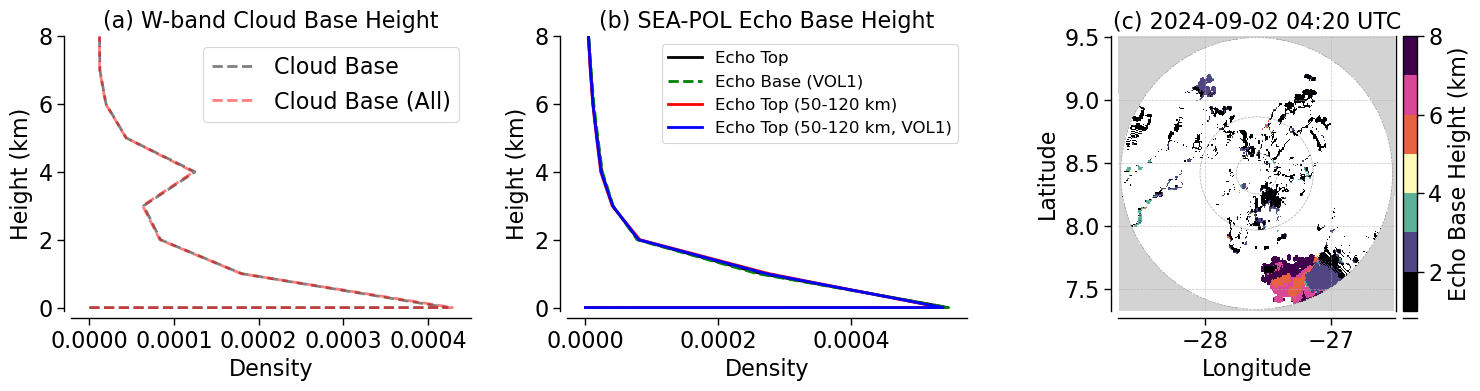

In [31]:
#Plot pdf of wband cloud base and top height
fig, axs = plt.subplots(1,3,figsize=(15,4))

bins =np.concatenate(([-1],np.arange(0, 14000, 1000)))
seapol_bins = np.concatenate(([-1],np.arange(0, 18500, 1000)))
cb_hist, bin_edges_cb = np.histogram(wband_cloudbase, bins=bins, density=True)
cb_hist2, bin_edges_cb2 = np.histogram(wband.cloud_base_height_amsl, bins=bins, density=True)
ct_hist, bin_edges_ct = np.histogram(wband_cloudtop, bins=bins, density=True)
ct_hist2, bin_edges_ct2 = np.histogram(wband.cloud_top_height_amsl, bins=bins, density=True)
eth_hist, bin_edges_eth = np.histogram(seapol_echobase_all.echo_base_height, bins=seapol_bins, density=True)
eth_hist2, bin_edges_eth2 = np.histogram(seapol_echobase_all_50_120.echo_base_height, bins=seapol_bins, density=True)
eth_hist3, bin_edges_eth3 = np.histogram(seapol_echobase_vol1_50_120.echo_base_height, bins=seapol_bins, density=True)
eth_hist4, bin_edges_eth4 =  np.histogram(seapol_echobase_vol1.echo_base_height, bins=seapol_bins, density=True)

#axs[0].plot(ct_hist,bin_edges_ct[:-1]/1000,color='black', linewidth=2,label='Cloud Top')
#axs[0].plot(ct_hist2,bin_edges_ct2[:-1]/1000,color='red', linewidth=2,label='Cloud Top (All)')
axs[0].plot(cb_hist,bin_edges_cb[:-1]/1000,color='gray', linestyle = '--', linewidth=2,label='Cloud Base')
axs[0].plot(cb_hist2,bin_edges_cb2[:-1]/1000,color='red', alpha = 0.5, linestyle = '--', linewidth=2,label='Cloud Base (All)')

#add a horizontal line at 12000
axs[0].axhline(12, color='black', linestyle='--', linewidth=1)

axs[0].set_xlabel('Density',fontsize=16)
axs[0].set_ylabel('Height (km)',fontsize=16)
axs[0].set_ylim([-.1,8])
axs[0].tick_params(axis='both', labelsize=16)
axs[0].legend(fontsize=16)
axs[0].set_title('(a) W-band Cloud Base Height', fontsize=16)

axs[1].plot(eth_hist,bin_edges_eth[:-1]/1000,color='black', linewidth=2,label='Echo Top')
axs[1].plot(eth_hist4,bin_edges_eth4[:-1]/1000,color='green', linestyle='--', linewidth=2,label='Echo Base (VOL1)')
axs[1].plot(eth_hist2,bin_edges_eth2[:-1]/1000,color='red', linewidth=2,label='Echo Top (50-120 km)')
axs[1].plot(eth_hist3,bin_edges_eth3[:-1]/1000,color='blue', linewidth=2,label='Echo Top (50-120 km, VOL1)')

axs[1].set_xlabel('Density',fontsize=16)
axs[1].set_ylabel('Height (km)',fontsize=16)
axs[1].set_ylim([-.1,8])
axs[1].tick_params(axis='both', labelsize=16)
axs[1].legend(fontsize=12)
axs[1].set_title('(b) SEA-POL Echo Base Height', fontsize=16)

cax = axs[2].pcolormesh(map_dbz.longitude, map_dbz.latitude, echo_base_height/1000, cmap=discrete_mask_cmap, vmin=1, vmax=8)
axs[2].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[2], orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('Echo Base Height (km)', fontsize=16)
dt_str = pd.to_datetime(seapol.time[index_map].values).strftime('%Y-%m-%d %H:%M')
axs[2].set_title('(c) ' + dt_str + ' UTC',fontsize=16)
axs[2].tick_params(axis='both', labelsize=16)
axs[2].set_xlabel('Longitude', fontsize=16)
axs[2].set_ylabel('Latitude', fontsize=16)

# Add grid lines 
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Add 120 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 50 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 18 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 18/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

#plt.savefig('../Plots/Fig_echo_base_top.pdf', bbox_inches='tight', dpi=300)